# Unsupervised Clustering of Urban Seismic Noise Using Convolutional Autoencoders on Spatially Dense Seismic Array Data

Written and Commented by Dylan Snover. 
March 4th, 2020

Seismic data recorded in urban environments contains human-generated 'cultural' noise that can inhibit observation of
signals originating naturally. Anthropogenic noise can conceal local and regional seismic events which contain valuable information about fault movement, mechanics, and geometry. The ability to identify microseismicity in real time is limited without the means to characterize and remove unwanted noise signals from the data. Recently, advances in machine learning have enabled researchers to detect local and regional earthquakes under the condition that the signal to noise ratio is above a certain threshold. In very active urban environments however, the signal
to noise ratio is rarely high enough to pick up these small events. In these cases, new methods must be introduced in order to characterize and remove cultural noise from the data. The goal of the research presented here is to classify and separate cultural noise signals from an active urban environment based on the features present in their spectrograms.

# Note: 
The outputs of some cells have been cleared to prevent exessive scrolling.


In [ ]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import time
import glob
import math
import shutil
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D, Cropping2D, BatchNormalization, Flatten, Bidirectional, Dropout, Reshape
from keras import regularizers
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers
from keras import metrics
from keras.utils import multi_gpu_model, plot_model
import random
from math import *
import json
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.linear_assignment_ import linear_assignment
from matplotlib.pyplot import savefig
from tensorflow.python.ops import math_ops
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN, OPTICS, Birch
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import hdbscan
from sklearn.metrics.pairwise import pairwise_distances
import struct
import matplotlib
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime
import sys
from IPython.display import HTML, Image
from matplotlib.animation import FuncAnimation

In [2]:
tic_total = time.time()

In [3]:
date_name = 'Feb21'

# Data:
The data were recorded on a spatially dense, 5200 geophone array in Long Beach, CA between March 6 and March 12, 2011. The entire data set is 161 hours of continuous seismic waveform recordings, around ~4Tb. To analyze the data we generated our own datasets from the 161 hours. The training data set was generated by randomly selectin stations, days, and hours to extract waveforms from. We isolated 1 day of data (March 6th) to be used as unseen test data. 

Preprocessing:  The hour long seismic records were chopped into 4 second waveforms with 3 seconds of overlap between samples. These waveforms were then normalized between values of -1 and 1. The short time fourier transform was applied and only the amplitude information was kept. The resulting spectrograms had the dimensions [126,41,1]. In this example we use a training data set of 2,005,920 spectrogram images.

In [4]:
# Define dataset file locations
train_dataname = '/home/dsnover/LB/January_LB/Overlapping_Dataset_Generation/Overlap_TrainingData_Jan27.hdf5'
mar6_testdata = '/home/dsnover/LB/January_LB/Overlapping_Dataset_Generation/LB_March6_Overlap_Active_TestDataset_Jan27.hdf5'
mar12_testdata = '/home/dsnover/LB/January_LB/Overlapping_Dataset_Generation/LB_March12_Overlap_NonActive_TestDataset_Jan27.hdf5'

In [5]:
# Designate GPU to run model training
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
#limit GPU memory use:
GPUfrac=1.00
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPUfrac)#, allow_growth=True)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

In [7]:
np.random.seed(812)

# Load in training data spectrograms, remove mean, and scale to unit variance.

In [ ]:
with h5py.File(train_dataname, 'r') as f:
    #samples, frequency bins, time bins, amplitude 
    m, n, o, p = f['spects'].shape
    # print(m,n,o,p)   
    
    # load data onto CPU
    X = f['spects'][:] 
    #Scale Data -  rm mean and scale each by stanrdard deviation of each feature (pixel)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True,
                                            samplewise_std_normalization=True)
    # fit the scaler to the training data
    datagen.fit(X) 
    # scale the data
    X = datagen.standardize(X) 

    #Split data into training data(80%) and validation data (20%)
    X_train, X_val = train_test_split(X, test_size=0.2, 
                                      shuffle=True, 
                                      random_state=812)                                                                     
    # clean up memory
    del X

# Construct autoencoder & encoder: 
Convolutional  autoencoders  (CAE)  are  designed  to compress images down to a lower dimensional latent space, and then reconstruct them based on these latent features. During the training process the encoder learns to extract salient features ofthe original image so the reconstruction results in the lowest loss.Once the model is trained, the latent features representing theoriginal images can be used to cluster the samples into separableclasses

W0223 13:54:22.292847 140220582143808 deprecation_wrapper.py:119] From /home/dsnover/miniconda3/envs/tf2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0223 13:54:22.294198 140220582143808 deprecation_wrapper.py:119] From /home/dsnover/miniconda3/envs/tf2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0223 13:54:22.302591 140220582143808 deprecation_wrapper.py:119] From /home/dsnover/miniconda3/envs/tf2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 126, 41, 1)        0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 120, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 20, 8)         208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 10, 16)        3216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 5, 32)         4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 2, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
__________

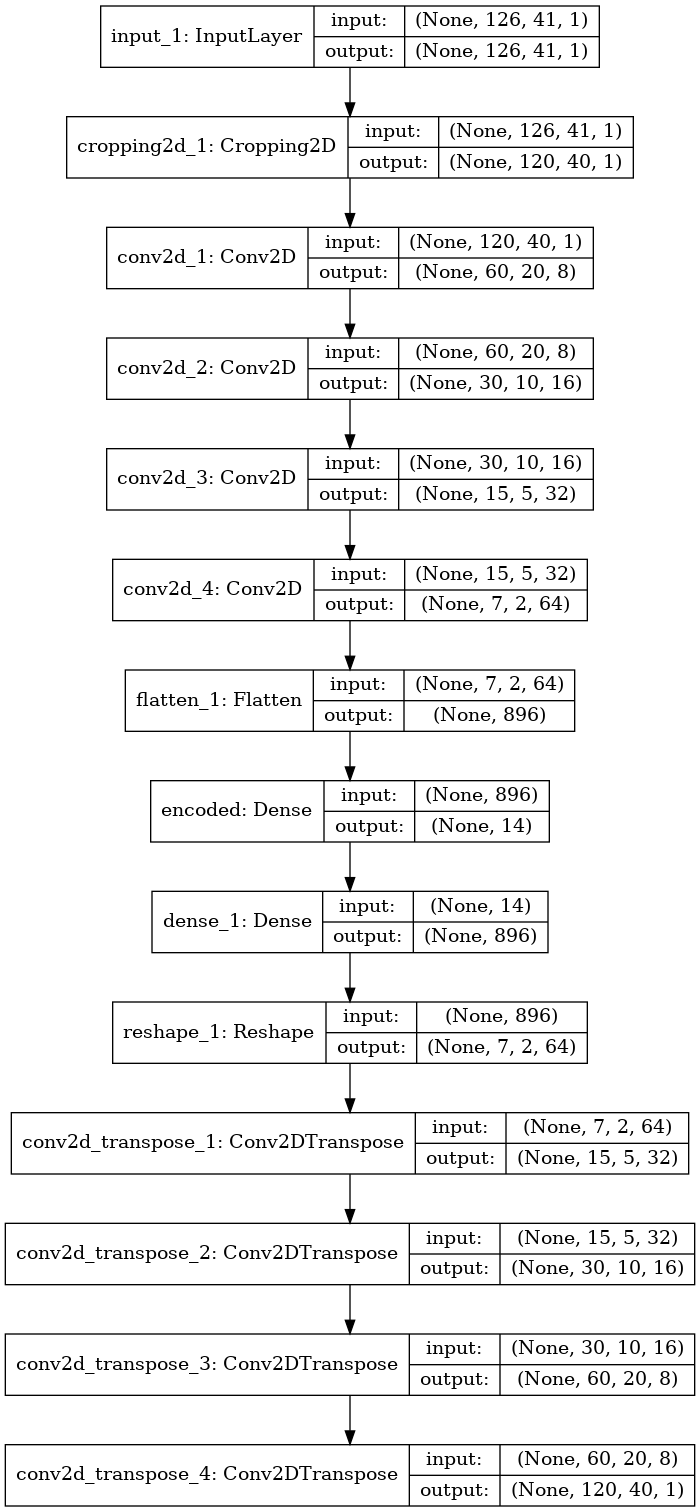

In [15]:
img_input = Input(shape=(n, o, p)) # input shape:[126,41,1]

#Encoder model for CAE
#---------------------------------------------------------------------------
# intial depth increases by 2x each layer
depth      = 8                                                      
strides    = 2
activation = 'relu'
# ReLU initial weights
kernel_initializer='glorot_uniform'
latent_dim = 14

#Crop to dimensions of [120,40,1] to allow for reconstruction
e = Cropping2D(cropping = ((0, 6), (0, 1)))(img_input) 
e = Conv2D(depth*2**0, (5,5), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same') (e)
e = Conv2D(depth*2**1, (5,5), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same') (e)
e = Conv2D(depth*2**2, (3,3), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same') (e)
e = Conv2D(depth*2**3, (3,3), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='valid')(e)

shape_before_flattening = K.int_shape(e)
x = Flatten()(e)
#Embedded latent space: 14 dimensions (features)
encoded = Dense(latent_dim, activation=activation, name='encoded')(x)



#Decoder model for CAE (Reverse Operations)
#---------------------------------------------------------------------------
d = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(encoded)
d = Reshape(shape_before_flattening[1:])(d)
d = Conv2DTranspose(depth*2**2, (3,3), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same')(d)
d = Conv2DTranspose(depth*2**1, (5,5), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same')(d)
d = Conv2DTranspose(depth*2**0, (5,5), strides=strides, activation=activation, kernel_initializer=kernel_initializer, padding='same')(d)


decoded = Conv2DTranspose(1, (5,5), strides=strides, activation='linear', kernel_initializer=kernel_initializer, padding='same')(d) 

# Define Autoencoder Input: Sprectrograms & Output: Reconstructions
autoencoder = Model(inputs=img_input, outputs=decoded, name='autoencoder')

#Define Encoder Input: Sprectrograms & Output: Compressed image representations (embedded latent space)
encoder = Model(inputs=img_input, outputs=encoded, name='encoder')


autoencoder.summary()

architecture_fname = 'CAE_Model_{}.png'.format(date_name)
plot_model(autoencoder, to_file=architecture_fname, show_shapes=True)
Image(filename=architecture_fname)

# Set hyperparameters for Initial CAE model Training:
To ensure the model is learning important features and not overfitting(memorizing the data) or underfitting(generalizing the data), we need to set hyperparameters that effect the models training. The learning rate, batch size, number of epochs are the primary factors that effect learning. The parameters below have been fine tuned through a long process of trial and error. An additional step we take to prevent overfitting is the use of validation data that is not used to train the model, but is used to validate the models performance after each epoch.  The loss for the validation data is used as an indicator of over fitting. If the loss for the validation data increases for conecutive epochs, the model is overfitting. We implement an early stopping criteria that halts training and restores the best model parameters if the validation data does not decrease for 10 consectutive epochs.  

In [16]:
LR = 0.0001             #Learning rate

n_epochs = 600          #Number of epochs

batch_sz = 512          #Batch size

#create log file to record training & validation loss 
logger_fname = 'HistoryLog_LearningCurve.csv'.format(date_name)
csv_logger = CSVLogger(logger_fname)

# Early stopping halts training after validation loss stops decreasing for 10 consectutive epochs
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1,
                           mode='min', restore_best_weights=True)
            

HistoryLog_LearningCurve.csv


In [17]:
optim = optimizers.adam(lr=LR)             #Adaptive learning rate optimization algorithm (Adam)
loss = 'mse'                               #Mean Squared Error Loss function

#Compile Encoder & Autoencoder(initialize random filter weights)
encoder.compile(loss=loss,optimizer=optim) 
autoencoder.compile(loss=loss,
                  optimizer=optim,
                  metrics=[metrics.mae])   

W0223 13:54:27.065565 140220582143808 deprecation_wrapper.py:119] From /home/dsnover/miniconda3/envs/tf2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Run training and show training loss (learning curve) for hyperparameter validation

In [ ]:
tic=time.time()
autoencoder.fit(X_train, X_train[:,:120,:40,:], batch_size=batch_sz, epochs=n_epochs, validation_data=(X_val, X_val[:,:120,:40,:]), callbacks=[csv_logger, early_stop])  
toc = time.time()
print('Elapsed Time : {0:4.1f} minutes'.format((toc-tic)/60))

In [19]:
hist = np.genfromtxt(logger_fname, delimiter=',', skip_header=1, names=['epoch', 'train_mse_loss', 'train_mae_loss', 'val_mse_loss', 'val_mae_loss'])

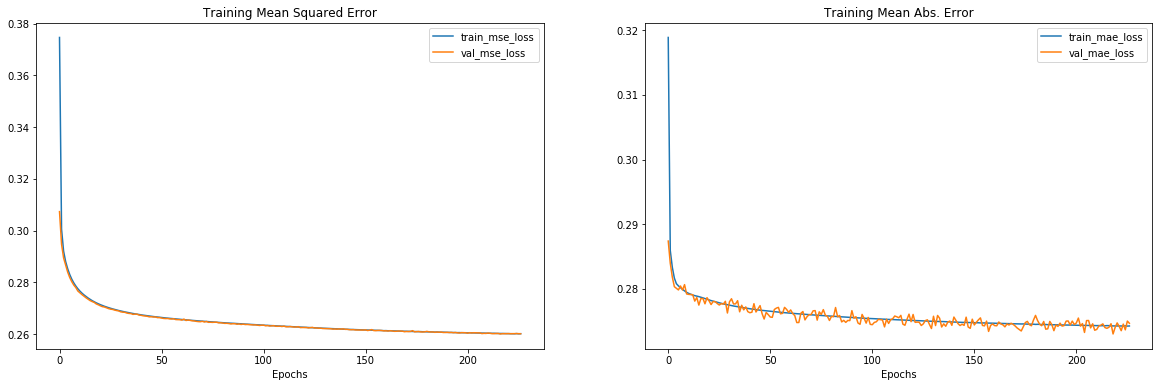

In [20]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,2)
plt.plot(hist['epoch'], hist['train_mae_loss'], label='train_mae_loss')
plt.plot(hist['epoch'], hist['val_mae_loss'], label='val_mae_loss')
plt.xlabel('Epochs')
plt.title('Training Mean Abs. Error')
plt.legend()

plt.subplot(1,2,1)
plt.plot(hist['epoch'], hist['train_mse_loss'], label='train_mse_loss')
plt.plot(hist['epoch'], hist['val_mse_loss'], label='val_mse_loss')
plt.xlabel('Epochs')
plt.title('Training Mean Squared Error')
plt.legend()

plt.savefig('./Figures/MSE_MAE_Subplots_Loss_Learning_Curve.png')
plt.show()

In [21]:
#Save initial model architectures with weights. 
autoencoder.save('Saved_Autoencoder_{}.hdf5'.format(date_name))
encoder.save("Saved_Encoder1_{}.hdf5".format(date_name))

# Show validation data reconstructions:
We can observe how well the model is learning important features in the input spectrograms by looking at the autoencoders ability to reconstruct the original input images from the validation data set.  Because we are compressing each spectrogram image from 4800 features down to 14, we expect to see a fair amount of smoothing of features in the reconstructed images. 
A well trained autoencoder will retain most of the amplitude information (observed in the color bar scales) and will preserve local structure (the strongest signals are seen in the same are in both the original and reconstructed images). 

In [22]:
val_reconst = autoencoder.predict(X_val, verbose = 1) #reconstruction of validation data
val_enc = encoder.predict(X_val, verbose = 1)         #embedded latent space samples of validation data
enc_train = encoder.predict(X_train, verbose = 1)     #embedded latent space samples of training data

1604736/1604736 [==============================] - 90s 56us/step


In [23]:
#Save embedded latent space data for ease of access in future.
with h5py.File('./{}_Training_LatentSpaceData.hdf5'.format(date_name), 'w') as nf:
    nf.create_dataset('Train_EncodedData', data=enc_train, dtype=enc_train.dtype)
    nf.create_dataset('Val_EncodedData', data=val_enc, dtype=val_enc.dtype)

In [24]:
#Axis labels to represent time in seconds rather than time bins from S.T.F.T.
secs = ['0', '1', '2', '3', '4']
secs_pos = np.arange(0,50,10)

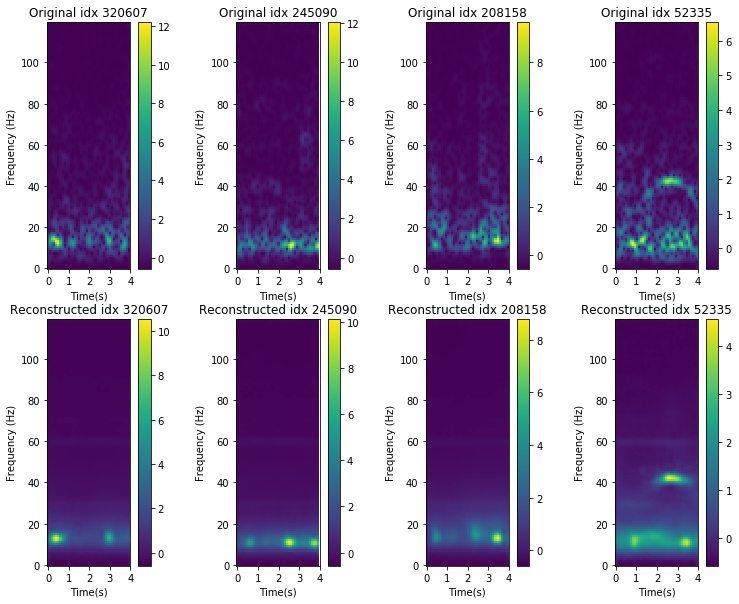

In [25]:
good_idx = [17343, 225302, 170169, 394137] #samples to compare (Useful in previous models, arbitrary now)
cnt = 0
fig = plt.figure(figsize=(13,10))
for imgIdx in np.random.randint(0,len(X_val),4):
    cnt = cnt+1
    # Top row shows original input spectrograms
    fig.add_subplot(2,4,cnt)
    plt.imshow(np.reshape(X_val[imgIdx,:120,:40,:], (120,40)))
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
    plt.title(f'Original idx {imgIdx}')
    
    # Bottom row shows the reconstructed spectrograms (CAE output)
    fig.add_subplot(2,4,cnt+4)
    plt.imshow(np.reshape(val_reconst[imgIdx], (120,40)))
    plt.colorbar()
    plt.title(f'Reconstructed idx {imgIdx}')
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
plt.savefig('./Figures/Reconstruction_Examples_[].png'.format(date_name))
plt.show()
plt.close()

# Show orignal spectrogram, embedded representation, & reconstruction

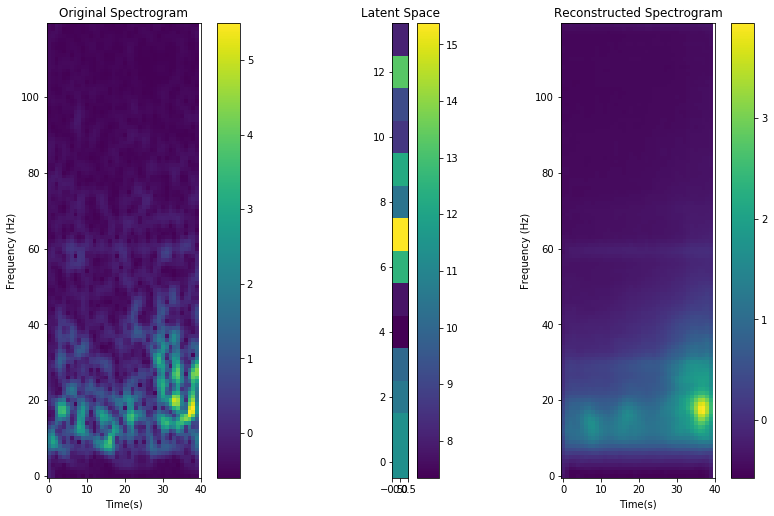

In [26]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,8))
idx =211560

gs = GridSpec(nrows=3, ncols=3, width_ratios=[1,.5,1], height_ratios = [1,0,0])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

#Original spectrogram
cb0 = ax0.imshow(np.reshape(X_val[idx,:120, :40, :], (120,40)))
ax0.set_ylabel('Frequency (Hz)')
ax0.set_xticks(secs_pos, secs)
ax0.set_xlabel('Time(s)')
ax0.invert_yaxis()      
plt.colorbar(cb0, ax = ax0)
ax0.set_title('Original Spectrogram')

#Latent space image representation
cb1 = ax1.imshow(val_enc[idx].reshape(14,1), cmap='viridis')
ax1.invert_yaxis()
ax1.set_aspect(2)
plt.colorbar(cb1, ax = ax1)
ax1.set_title('Latent Space')

#Reconstructed Image
cb2 = ax2.imshow(np.reshape(val_reconst[idx,:, :, :], (120,40)))
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xticks(secs_pos, secs)
ax2.set_xlabel('Time(s)')
ax2.invert_yaxis()      
plt.colorbar(cb2, ax = ax2)
ax2.set_title('Reconstructed Spectrogram')
         
fig.tight_layout()
fig.savefig('./Figures/original_embedded_reconst.png')
plt.show()

# Determine the optimal number of clusters in embedded training data:
Perform gap statistic calculation. The gap statistic is a measure of clustering performance that compares how well a data set can be clustered against a reference distribution. Reference distributions are those where no meaning meaningful clusters exist(i.e. a normal or uniform distrubtion - both were tested here). 
Additional information about the gap statistic can be found in the following paper:
https://statweb.stanford.edu/~gwalther/gap

In [27]:
#For sake of time and computational efficiency-take 50,000 random samples 
#from training data to compute gap statistic
rand_idx = np.random.randint(0,len(X_train),50000)
kmeans_enc = np.zeros([50000,14])
for i in range(len(rand_idx)):
    kmeans_enc[i] = enc_train[rand_idx[i]]
print(kmeans_enc.shape)

(50000, 14)


In [28]:
# Calculate min, max, mean, and standard deviation of each features in embedded latent space samples
feat_min = np.amin(kmeans_enc, axis=0)
feat_max = np.amax(kmeans_enc, axis=0)
feat_mean = np.mean(kmeans_enc, axis=0)
feat_std = np.std(kmeans_enc, axis=0)



In [29]:
# Generate a Gaussian normal distribtuion with 50,000 samples based on feature mean and standard deviaton .
gauss = np.zeros([len(feat_mean), len(kmeans_enc)])

# Generate a uniform reference distribtuion with 50,000 samples based on feature min and max. 
uniform = np.zeros([len(feat_mean), len(kmeans_enc)])

for i in range(0, len(feat_mean)):
    gauss[i] = np.random.normal(loc=feat_mean[i], scale =feat_std[i], size=len(kmeans_enc))
    uniform[i] = np.random.uniform(low=feat_min[i], high=feat_max[i], size=len(kmeans_enc))

In [30]:
# Run Kmeans with a range of number of clusters between (2-20) on embedded latent space training samples
# for each number of clusters, Kmeans finds the cluster centers that minimizes the sum-of-squares distance (intertia)
# between the samples assigned to a cluster, and that cluster centroid and the cluster center

tic = time.time()
inertia = []
for i in np.arange(2, 20, 1):
    
    kmeans_model_test = KMeans(n_clusters=i, n_init=10, precompute_distances=True, random_state=812, verbose = 0).fit(kmeans_enc)
    inertia.append(kmeans_model_test.inertia_)

np.savez('Kmeans_inertia_{}.npz'.format(date_name), inertia)
toc = time.time()
print('Latent Space Representation KMeans Computation Time : {0:4.1f} minutes'.format((toc-tic)/60))

Latent Space Representation KMeans Computation Time :  1.3 minutes


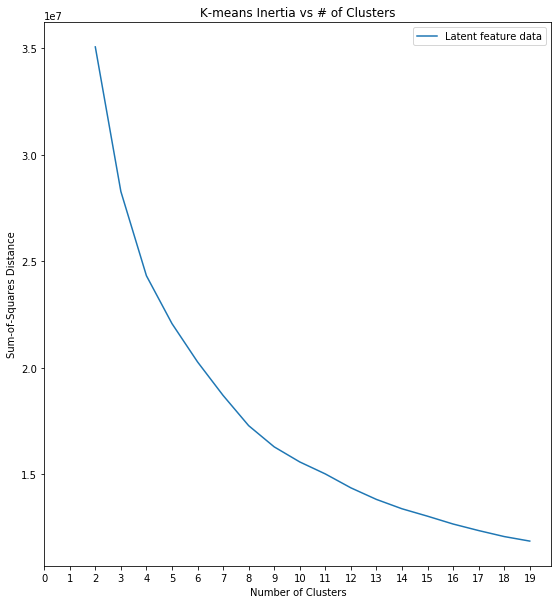

In [31]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
plt.plot(np.arange(2,20,1), inertia, label='Latent feature data')
plt.xlabel('Number of Clusters')
ax = fig.gca()
ax.set_xticks(np.arange(0,20,1))
plt.ylabel('Sum-of-Squares Distance')
plt.title("K-means Inertia vs # of Clusters")
plt.legend()
plt.savefig('./Figures/KMeans_Inertia_vs_NumClusters_{}.png'.format(date_name))

plt.show()

In [32]:
# Repeat this process with the data taken from the gaussian normal  reference distribution

tic = time.time()
inertia_gauss =[]
for i in np.arange(2, 20, 1):
    kmeans_model_gauss = KMeans(n_clusters=i, n_init=10, precompute_distances=True, random_state=812).fit(gauss.T)
    inertia_gauss.append(kmeans_model_gauss.inertia_)

toc = time.time()
print('Reference Gaussian Distribution KMeans Computation Time : {0:4.1f} minutes'.format((toc-tic)/60)) 

Reference Gaussian Distribution KMeans Computation Time :  2.8 minutes


In [33]:
# Repeat this process with the data taken from the uniform reference distribtion

tic = time.time()
inertia_uniform =[]
for i in np.arange(2, 20, 1):
    kmeans_model_uniform = KMeans(n_clusters=i, n_init=10, precompute_distances=True, random_state=812).fit(uniform.T)
    inertia_uniform.append(kmeans_model_uniform.inertia_)

toc = time.time()
print('Reference Unfiform Distribution KMeans Computation Time : {0:4.1f} minutes'.format((toc-tic)/60))   

Reference Unfiform Distribution KMeans Computation Time :  2.3 minutes


# Calculate and show Gap Statistic:
Show how the sum-of-squares distance decreases as the number of clusters increases. Show this curve for both the embedded training data and the reference distributions. The difference between the log of these values is the gap statistic. The cluster number where the greatest change in slope occurs is the optimal number of clusters. In the plot shown below, we estimate the optimal number of clusters to be ~8. This is based on the very subtled change in slope of the gap statistic curve for both a normal and uniform  reference distribution.

In [34]:
gap_uniform = np.log(np.asarray(inertia_uniform)) - np.log(np.asarray(inertia))
gap_gauss = np.log(np.asarray(inertia_gauss)) - np.log(np.asarray(inertia))

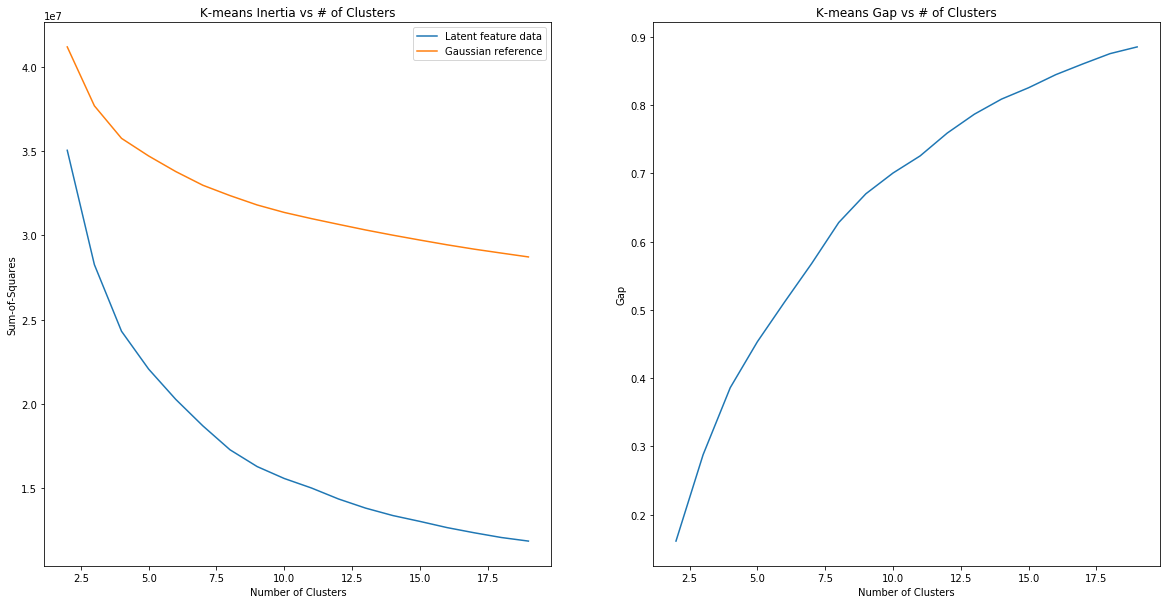

In [35]:
#Plots for Gap statistics based on gaussian normal refernce distribution
fig = plt.figure(figsize=(20,10))

fig.add_subplot(1,2,1)
plt.plot(np.arange(2,20,1), inertia, label='Latent feature data')
plt.plot(np.arange(2,20,1), inertia_gauss, label='Gaussian reference')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-of-Squares')
plt.title("K-means Inertia vs # of Clusters")
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(np.arange(2,20,1), gap_gauss, label='Gaussian Gap')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap')
plt.title("K-means Gap vs # of Clusters")

plt.savefig('./Figures/Kmeans_Gaussian_Gap_{}.png'.format(date_name))

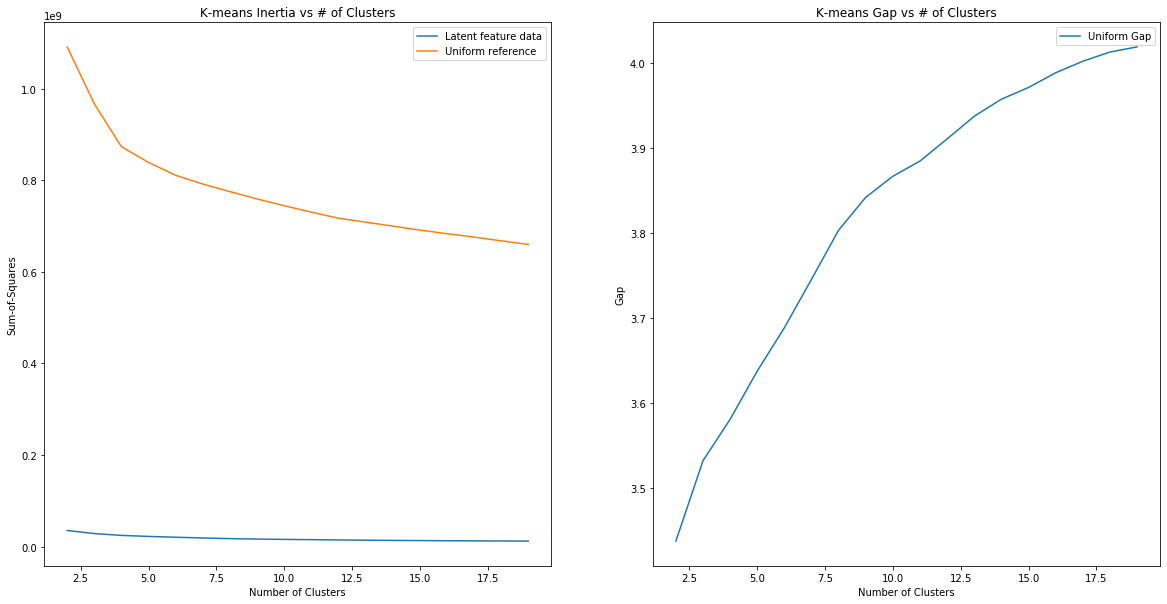

In [36]:
#Plots for Gap statistics based on uniform refernce distribution

fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
plt.plot(np.arange(2,20,1), inertia, label='Latent feature data')
plt.plot(np.arange(2,20,1), inertia_uniform, label='Uniform reference')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-of-Squares')
plt.title("K-means Inertia vs # of Clusters")
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(np.arange(2,20,1), gap_uniform, label='Uniform Gap')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap')
plt.title("K-means Gap vs # of Clusters")
plt.legend()

plt.savefig('./Figures/Kmeans_Uniform_Gap_{}.png'.format(date_name))

In [39]:
#Save Inertia for each data type to save time later.
with h5py.File('./{}_GapStatistics.hdf5'.format(date_name), 'w') as nf:
    nf.create_dataset('inertia_testdata', data=inertia)
    nf.create_dataset('inertia_gauss', data=inertia_gauss)
    nf.create_dataset('inertia_uniform', data=inertia_uniform)

In [40]:
#Free up CPU space by deleteing uneeded variables
del feat_min, feat_max, feat_mean, feat_std, gauss, uniform
del inertia, kmeans_model_test, inertia_gauss, kmeans_model_gauss
del inertia_uniform, kmeans_model_uniform, gap_gauss, gap_uniform

# Plotting Definitions:
These definitions are used after the DEC model is trained. They are intended to provide a visual indication of clustering performance. 

In [42]:
def print_cluster_size(labels):
    """
    Shows the number of samples assigned to each cluster. 
    # Example 
    ```
        print_cluster_size(labels=kmeans_labels)
    ```
    # Arguments
        labels: 1D array  of clustering assignments. The value of each label corresponds to the cluster 
                that the samples in the clustered data set (with the same index) was assigned to. Array must be the same length as
                data.shape[0]. where 'data' is the clustered data set. 
    """
    num_labels = max(labels) + 1
    for j in range(0,num_labels):
        label_idx = np.where(labels==j)[0]
        print("Label " + str(j) + ": " + str(label_idx.shape[0]))

In [43]:
def print_all_clusters(data, labels, num_clusters):
    """
    Shows six examples of spectrograms assigned to each cluster. 
    # Example 
    ```
        print_all_clusters(data=X_train, labels=kmeans_labels, num_clusters=10)
    ```
    # Arguments
        data: data set (4th rank tensor) that was used as the input for the clustering algorithm used.
        labels: 1D array  of clustering assignments. The value of each label corresponds to the cluster 
                that the samples in 'data' (with the same index) was assigned to. Array must be the same length as
                data.shape[0].
        num_clusters: The number of clusters that the data was seperated in to.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """
    fig1=plt.figure() 
    for cluster_num in range(0,num_clusters):
        fig = plt.figure(figsize=(14,5))
        num_labels = max(labels) + 1
        cnt = 0
        label_idx = np.where(labels==cluster_num)[0]
         
        if len(label_idx) < 6:
            for i in range(len(label_idx)):
                fig.add_subplot(1,6,i+1)
                plt.imshow(np.reshape(data[label_idx[i],:], (126,41)))
                plt.ylabel('Frequency (Hz)')
                plt.xticks(secs_pos, secs)
                plt.xlabel('Time(s)')
                plt.gca().invert_yaxis()
                plt.colorbar()
        else: 
            for i in range(0,6):
                cnt = cnt + 1
                fig.add_subplot(1,6,cnt)
                plt.imshow(np.reshape(data[label_idx[i],:], (126,41)))
                plt.ylabel('Frequency (Hz)')
                plt.xticks(secs_pos, secs)
                plt.xlabel('Time(s)')
                plt.gca().invert_yaxis()
                plt.colorbar()
             

        plt.suptitle('Label {}'.format(cluster_num), ha='left', va='center', fontsize=28)    
        plt.tight_layout()
    
    plt.show()
    

# Choose Cluster Number and add clustering layer into  architecture
Deep embedded clustering is a method that seeks to improve clustering performance based on the cluster assignment of each embedded latent space sample. The method is considered a fine tuning step as it assumes the initial centroid locations found from KMeans is accurate. The model parameters are updated in a way that maximizes seperability  between embedded latent samples assigned to different groups. For more information: the following paper describes the algoirth in detail:http://proceedings.mlr.press/v48/xieb16.pdf


NOTE: The clustering layer architecture and training algorithm were derived from code written as part of the above paper. The full code can be found at: https://github.com/XifengGuo/DEC-keras/blob/master/DEC.py   Minor changes were made to the code to tailor the algorithm to the needs of this research. 

In [44]:
n_clusters = 8 #From Uniform Gap Test (very subtle elbow)

...Finetuning...


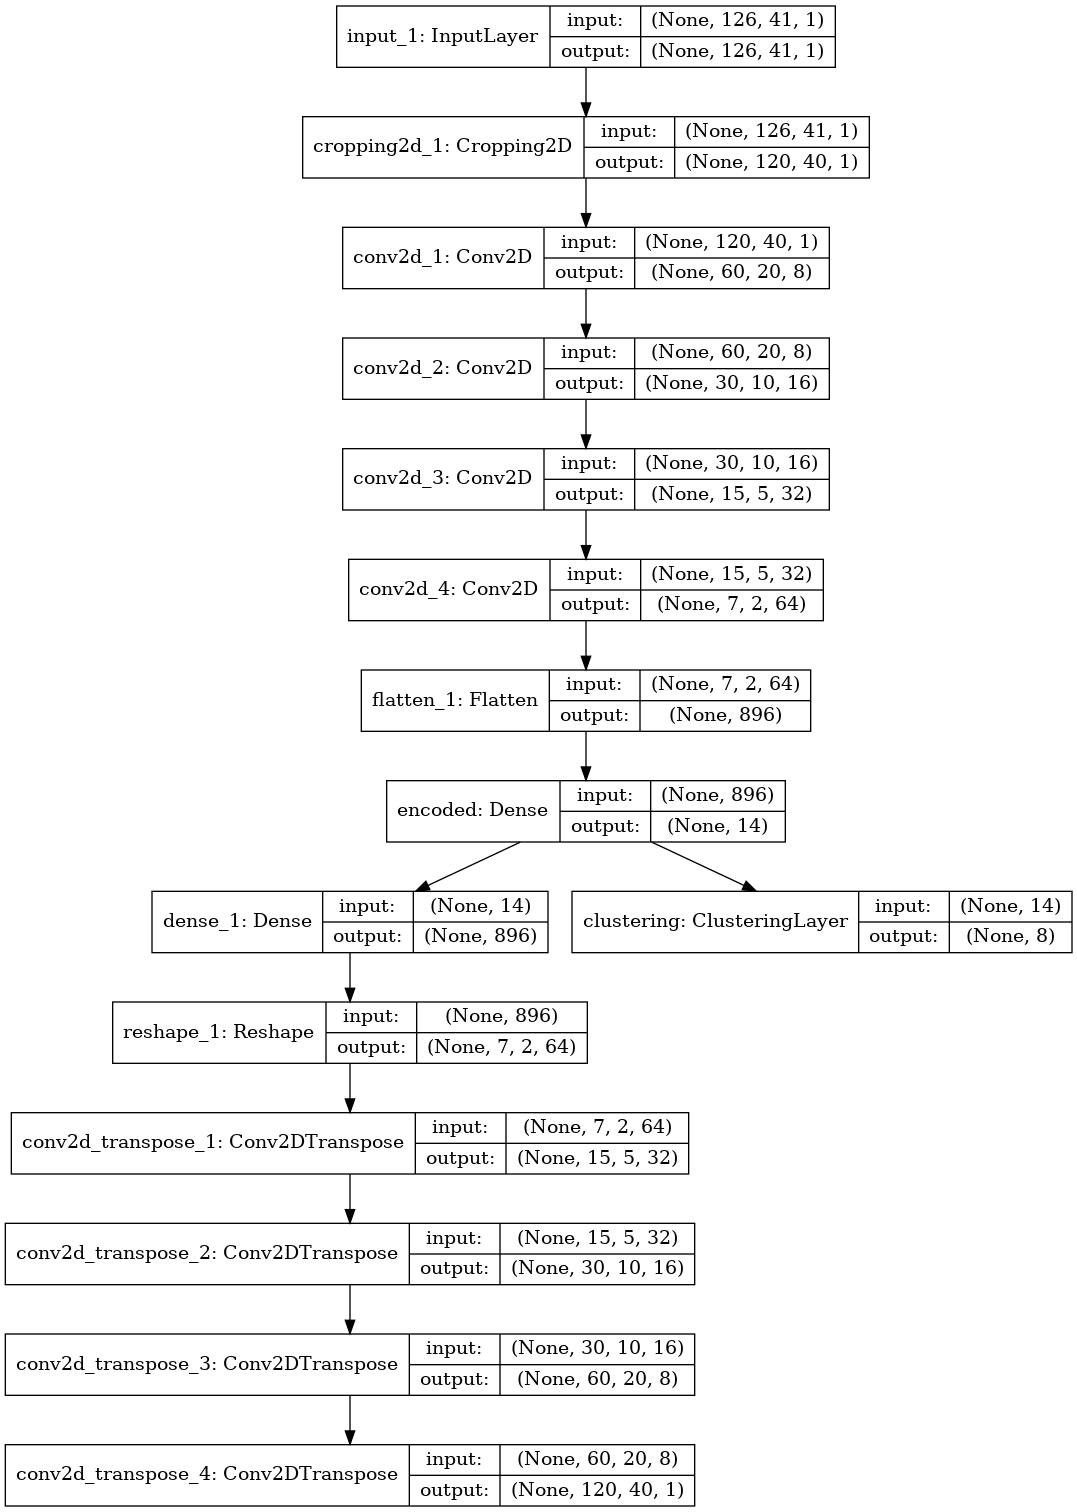

In [45]:
#### clustering layers:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs): #self is place holder for futre object 
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        #initialize object attributes
        self.n_clusters = n_clusters 
        self.alpha = alpha #exponent for soft assignment calculation
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)       #Feed embedded samples to 
                                                                                        #clustering layer
    
model = Model(inputs=autoencoder.input, outputs=[clustering_layer, autoencoder.output]) #Input: Spectrograms, 
                                                                                        #Output: Cluster assignments 
                                                                                        #      & Reconstructions            
                                                                                        
model.compile(loss=['kld',loss], loss_weights=[0.1, .9], optimizer=optim) # Initialize model parameters

#Save and Show full DEC model architecture
from keras.utils import plot_model
DEC_model_fname = 'DEC_CAE_Model_{}.png'.format(date_name)
plot_model(model, to_file=DEC_model_fname, show_shapes=True)
from IPython.display import Image
Image(filename=DEC_model_fname)

In [46]:
enc_train = encoder.predict(X_train, verbose=1)    # generate embedded latent space training samples

### initializing the weights using Kmean and assigning them to the model
#---------------------------------------------------------------------------------------------------------------------------
kmeans = KMeans(n_clusters=n_clusters, n_init=100) # run kmeans with n_clusters, run 100 initializations to ensure accuracy

labels = kmeans.fit_predict(enc_train)             # get initial assignments

labels_last = np.copy(labels)                      # make copy of labels for future reference (see DEC training below)

# initialize the DEC clustering layer weights using cluster centers found initally by kmeans.                                                                         
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_]) 
   


1604736/1604736 [==============================] - 90s 56us/step


In [47]:
# Parameters for the  DEC finetuning
#--------------------------------------------------------------------------------------------------------------------
batch_size=512                     # number of samples in each batch
tol = 0.001                        # tolerance threshold to stop training
loss = 0                           # initialize loss
index = 0                          # initialize index to start 
maxiter = 47250                    # number of updates to rub before halting. (~12 epochs)
update_interval = 315              # Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~12 updates/epoch)
index_array = np.arange(X_train.shape[0])

# Train Deep Embedded Clustering (DEC) Model

In [ ]:
###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    """
    Compute the target distribution p, given soft assignements, q. The target distribtuion is generated by giving
    more weight to 'high confidence' samples - those with a higher probability of being a signed to a certain cluster. 
    This is used in the KL-divergence loss function.
    # Arguments
        q: Soft assignement probabilities - Probabilities of each sample being assigned to each cluster.
    # Input:
         2D tensor of shape [n_samples, n_features].
    # Output:
        2D tensor of shape [n_samples, n_features].
    """
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


tic = time.time()
loss_list = np.zeros([maxiter,3])                       # Keep track of loss function during training process
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, reconst  = model.predict(X_train, verbose=1) # Calculate soft assignment distribtuion & CAE reconstructions
        
        p = target_distribution(q)                      # Update the auxiliary target distribution p       
        
        labels = q.argmax(1)                            # Assign labels to the embedded latent space samples
        

        # check stop criterion - Calculate the % of labels that changed from previous update
        delta_label = np.sum(labels != labels_last).astype(np.float32) /labels.shape[0] 
        
        labels_last = np.copy(labels)                   # Generate copy of labels for future updates
        
        loss= np.round(loss, 5)                         # Round the loss 
        
        print('Iter %d' % ite)
        print('Loss: {}'.format(loss))
        print_cluster_size(labels)                      # Show the number of samples assigned to each cluster
        

        if ite > 0 and delta_label < tol:               # Break training if loss reaches the tolerance threshhold
            print('delta_label ', delta_label, '< tol ', tol)
            break
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_train.shape[0])]
    loss = model.train_on_batch(x=X_train[idx], y=[p[idx], X_train[idx,:120,:40,:]])
    index = index + 1 if (index + 1) * batch_size <= X_train.shape[0] else 0        
        
#Save model and model weights seperately
model.save_weights('./DEC_model_final_{}.h5'.format(date_name))
model.save('Saved_DEC_model_{}.hdf5'.format(date_name))

toc = time.time()
print('Deep Embedded Clustering Computation Time : {0:4.1f} minutes'.format((toc-tic)/60))


#  Show original spectrograms & reconstructions after DEC training

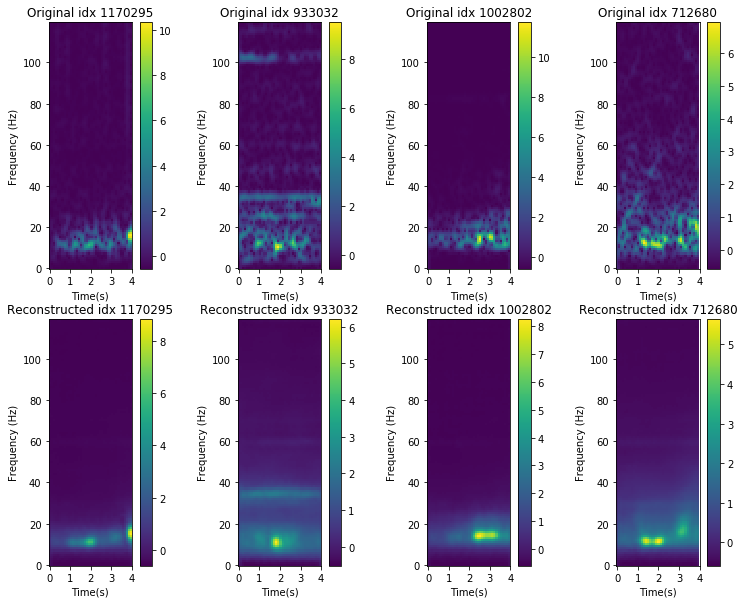

In [51]:
cnt = 0
fig = plt.figure(figsize=(13,10))
for imgIdx in np.random.randint(0,len(X_train),4):
    cnt = cnt+1
    fig.add_subplot(2,4,cnt)
    plt.imshow(np.reshape(X_train[imgIdx,:120,:40,:], (120,40)))
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
    plt.title(f'Original idx {imgIdx}')
    
    fig.add_subplot(2,4,cnt+4)
    plt.imshow(np.reshape(reconst[imgIdx], (120,40)))
    plt.colorbar()
    plt.title(f'Reconstructed idx {imgIdx}')
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
plt.savefig('./Figures/DEC_Reconstruction_Active_Examples.png')
plt.show()
plt.close()

In [52]:
del reconst, q, X_train, X_val, enc_train, val_reconst, val_enc, labels

# Feed unseen test data to trained DEC Model
Used trained DEC model to predict clustering assignments and generate reconstuctions of input spectrogram images from the unseen test data set. The test data set was isolated from the training data set and is drawn from all stations during an hour of data where vibrator trucks were actively producing signals in the array. 

In [53]:
# Load in test data
f_test = h5py.File(mar6_testdata, 'r')
m,n,o,p=f_test['spects'].shape

In [54]:
X_test= f_test['spects'][:]

In [55]:
# Remove mean and scale by standard deviation
X_test = datagen.standardize(X_test)

In [56]:
q, reconst = model.predict(X_test, verbose = 1)#Predict asignment probability of test data & generate reconstructions
labels = q.argmax(1)                           #Determine labels based on assignment probabilities
enc_test = encoder.predict(X_test)             #Generate embedded latent space test data samples

3008880/3008880 [==============================] - 293s 97us/step


# Generate reconstructions:
To gauge the reconstruction performance we generate plots of original spectrograms and reconstructions (oberving the amplitude retention and local structure preservation).

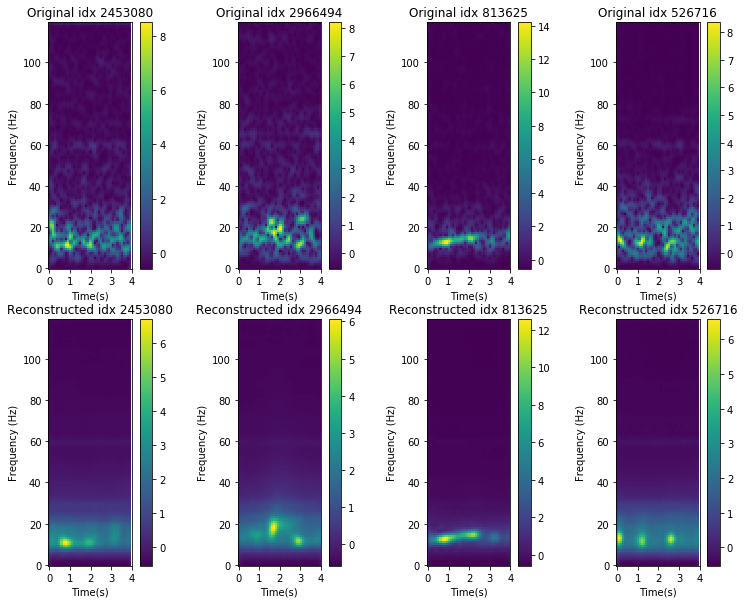

In [57]:
#Show examples of original spectrograms and reconstructions. 
cnt = 0
fig = plt.figure(figsize=(13,10))
for imgIdx in np.random.randint(0,len(X_test),4):
    cnt = cnt+1
    fig.add_subplot(2,4,cnt)
    plt.imshow(np.reshape(X_test[imgIdx,:120,:40,:], (120,40)))
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
    plt.title(f'Original idx {imgIdx}')
    
    fig.add_subplot(2,4,cnt+4)
    plt.imshow(np.reshape(reconst[imgIdx], (120,40)))#, vmin = c_min, vmax = c_max/2)
    plt.colorbar()
    plt.title(f'Reconstructed idx {imgIdx}')
    plt.gca().invert_yaxis()
    plt.ylabel('Frequency (Hz)')
    plt.xticks(secs_pos, secs)
    plt.xlabel('Time(s)')
plt.savefig('./Figures/DEC_Reconstruction_Examples.png')
plt.show()
plt.close()

# Show 5 examples of clustering assignments
To estimate how well the clustering algorithm is grouping similar spectrograms, we look at 5 examples of spectrograms that were assigned to each cluster. A well performing DEC model will group spectrorgams that are visually similar.

We also show the size of each cluster to ensure that each cluster is being utilized in the algorithm  and that one cluster is not dominating all other assignments. If either of these conditions are apperent, it is an idication that the DEC model is converging to a trivial solution.  

In [58]:
# Show the number of samples assigned to each cluster
print_cluster_size(labels)

Label 0: 661590
Label 1: 550612
Label 2: 228769
Label 3: 678363
Label 4: 464037
Label 5: 193671
Label 6: 58795
Label 7: 173043


<Figure size 432x288 with 0 Axes>

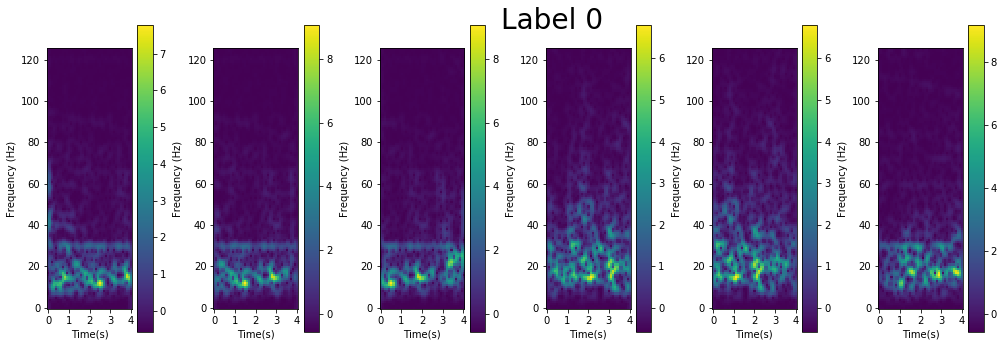

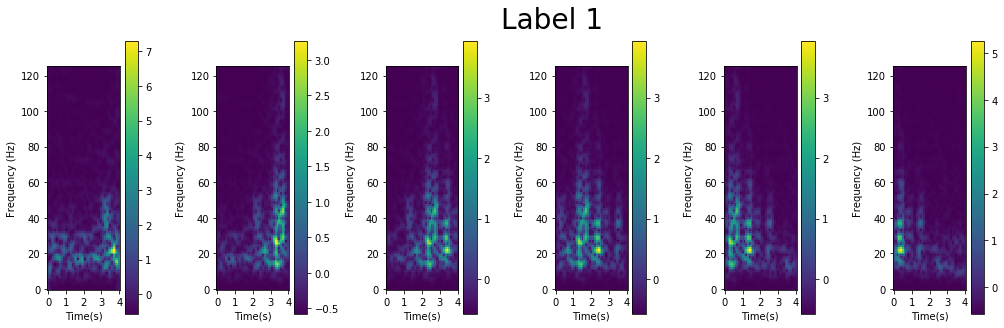

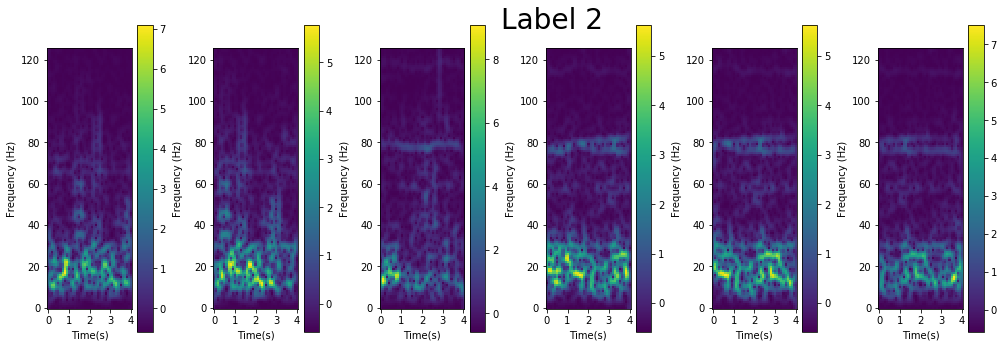

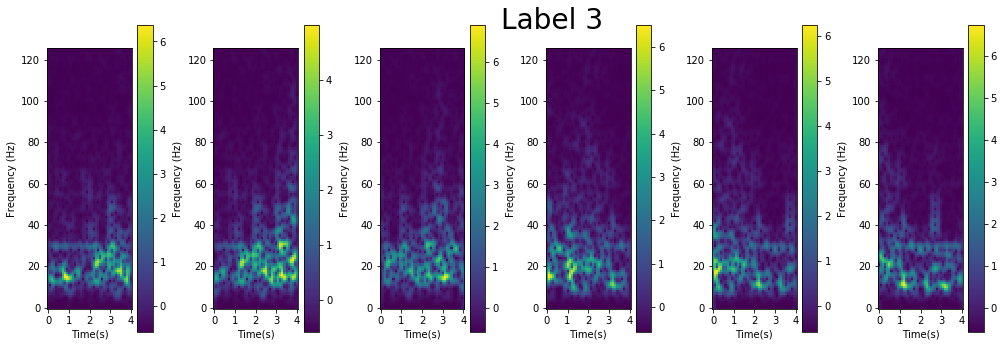

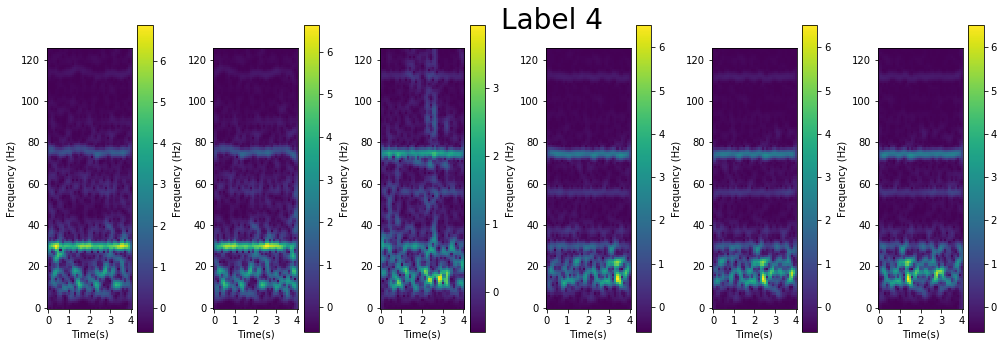

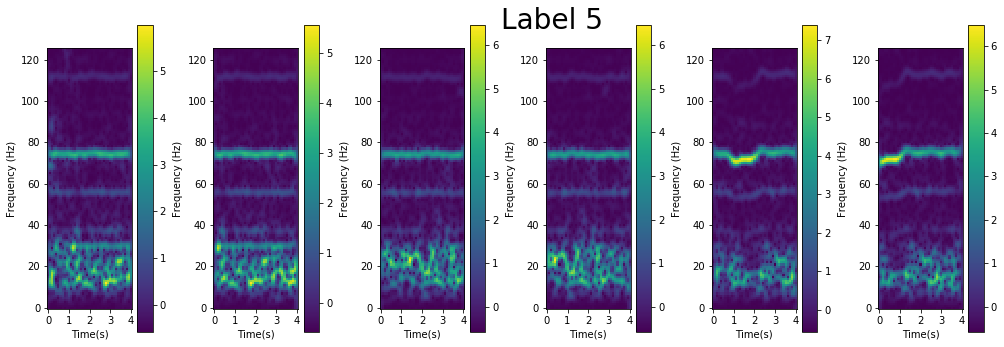

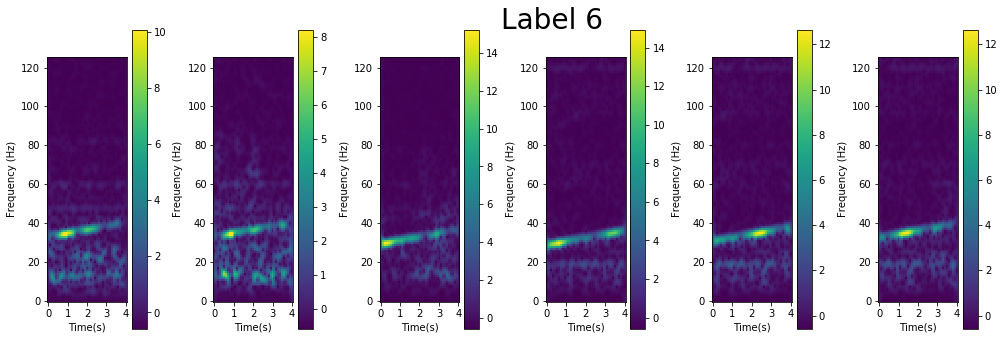

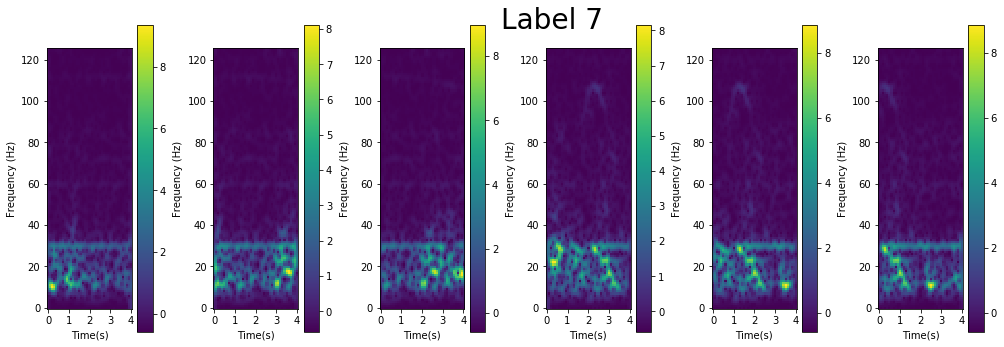

In [59]:
# Show six examples of sample spectrogram assigned to each cluster
print_all_clusters(X_test, labels, n_clusters)

In [60]:
#Save the index of all samples assigned to each cluster in seperate data sets for future analysis 
with h5py.File('./March6_Label_Indices_{}_DEC.hdf5'.format(date_name), 'w') as nf:
    for i in range(0, n_clusters):
        fname = 'label_{0}_indices'.format(i)
        label_idx = np.where(labels==i)[0]
        nf.create_dataset(fname, data=label_idx, dtype=label_idx.dtype)

In [61]:
# Save embedded latent space test data for future analysis.
with h5py.File('./{}_March6_LatentSpaceData.hdf5'.format(date_name), 'w') as nf:
    nf.create_dataset('March6_EncodedData', data=enc_test, dtype=enc_test.dtype)

# Calculate total running time and kill process upon completion

In [ ]:
toc_total = time.time()
print('Elapsed Time : {0:4.1f} minutes'.format((toc_total-tic_total)/60))

In [ ]:
%%javascript
Jupyter.notebook.session.delete();